In [1]:
# パッケージのimport
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image
import glob

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchsummary import summary

from torchviz import make_dot
from IPython.display import display

In [2]:
# Setup seeds
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
class Generator(nn.Module):
    def __init__(self,z_dim = 20, image_size = 64):
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(z_dim, image_size * 4,
                              kernel_size = 4, stride = 1),
            nn.BatchNorm2d(image_size * 4),
            nn.ReLU(inplace = True))
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 4, image_size * 2,
                              kernel_size = 8, stride = 2, padding = 1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace = True))
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size * 2,
                              kernel_size = 8, stride = 3, padding = 1),
            nn.BatchNorm2d(image_size * 2),
            nn.ReLU(inplace = True))
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(image_size * 2, image_size,
                              kernel_size = 8, stride = 3, padding = 1),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace = True))
        
        self.last = nn.Sequential(
            nn.ConvTranspose2d(image_size, 1,
                              kernel_size = 4, stride = 2, padding = 1),
            nn.Tanh())
        
    def forward(self, z):
        out = self.layer1(z)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.last(out)
        
        return out

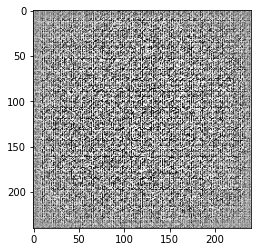

In [4]:
# 動作確認
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20, image_size=64)

# 入力する乱数
input_z = torch.randn(1, 20)

# テンソルサイズを(1, 20, 1, 1)に変形
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)

# 偽画像を出力
fake_images = G(input_z)

img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [5]:
G.to("cuda")

Generator(
  (layer1): Sequential(
    (0): ConvTranspose2d(20, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(8, 8), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(8, 8), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(8, 8), stride=(3, 3), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (last): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride

In [6]:
summary(G,(20,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]          82,176
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4          [-1, 128, 12, 12]       2,097,280
       BatchNorm2d-5          [-1, 128, 12, 12]             256
              ReLU-6          [-1, 128, 12, 12]               0
   ConvTranspose2d-7          [-1, 128, 39, 39]       1,048,704
       BatchNorm2d-8          [-1, 128, 39, 39]             256
              ReLU-9          [-1, 128, 39, 39]               0
  ConvTranspose2d-10         [-1, 64, 120, 120]         524,352
      BatchNorm2d-11         [-1, 64, 120, 120]             128
             ReLU-12         [-1, 64, 120, 120]               0
  ConvTranspose2d-13          [-1, 1, 240, 240]           1,025
             Tanh-14          [-1, 1, 2

In [7]:
class Discriminator(nn.Module):

    def __init__(self, z_dim=20, image_size=64):
        super(Discriminator, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, image_size, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))
        # 注意：白黒画像なので入力チャネルは1つだけ

        self.layer2 = nn.Sequential(
            nn.Conv2d(image_size, image_size*2, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer3 = nn.Sequential(
            nn.Conv2d(image_size*2, image_size*4, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer4 = nn.Sequential(
            nn.Conv2d(image_size*4, image_size*8, kernel_size=4,
                      stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True))

        self.layer5 = nn.Conv2d(image_size*8, image_size*4, kernel_size=4, stride=1)
        
        self.layer6 = nn.Conv2d(image_size*4, image_size*2, kernel_size=4,stride = 2)
        
        self.last =  nn.Conv2d(image_size*2, 1, kernel_size = 5, stride = 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.last(out)

        return out

In [31]:
# 動作確認
D = Discriminator(z_dim=20, image_size=64)

D.to("cuda")

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer5): Conv2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
  (layer6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
  (last): Conv2d(128, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [32]:
summary(D,(1,240,240))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 120, 120]           1,088
         LeakyReLU-2         [-1, 64, 120, 120]               0
            Conv2d-3          [-1, 128, 60, 60]         131,200
         LeakyReLU-4          [-1, 128, 60, 60]               0
            Conv2d-5          [-1, 256, 30, 30]         524,544
         LeakyReLU-6          [-1, 256, 30, 30]               0
            Conv2d-7          [-1, 512, 15, 15]       2,097,664
         LeakyReLU-8          [-1, 512, 15, 15]               0
            Conv2d-9          [-1, 256, 12, 12]       2,097,408
           Conv2d-10            [-1, 128, 5, 5]         524,416
           Conv2d-11              [-1, 1, 1, 1]           3,201
Total params: 5,379,521
Trainable params: 5,379,521
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.22
Forw

In [33]:
D

Discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (layer5): Conv2d(512, 256, kernel_size=(4, 4), stride=(1, 1))
  (layer6): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2))
  (last): Conv2d(128, 1, kernel_size=(5, 5), stride=(1, 1))
)

In [34]:


# 偽画像を生成
input_z = torch.randn(1, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z.to("cuda"))
print(fake_images.size())

# 偽画像をDに入力
d_out = D(fake_images)
print(d_out)
# 出力d_outにSigmoidをかけて0から1に変換
print(nn.Sigmoid()(d_out))

torch.Size([1, 1, 240, 240])
tensor([[[[-0.0062]]]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[[[0.4985]]]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [36]:
# Dの誤差関数のイメージ実装
# maximize log(D(x)) + log(1 - D(G(z)))


# ※ xが未定義なので動作はエラーになります
#---------------
x = next(iter(dataloader))

# 正解ラベルを作成
mini_batch_size = 2
label_real = torch.full((mini_batch_size,), 1)

# 偽ラベルを作成
label_fake = torch.full((mini_batch_size,), 0)

# 誤差関数を定義
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 真の画像を判定
d_out_real = D(x.to("cuda"))

# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
d_loss_real = criterion(d_out_real.view(-1), label_real)
d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
d_loss = d_loss_real + d_loss_fake



RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 1, 4, 4], but got 3-dimensional input of size [1, 240, 240] instead

In [13]:
# Gの誤差関数のイメージ実装
# maximize log(D(G(z)))


# ※ xが未定義なので動作はエラーになります
#---------------


# 偽の画像を生成して判定
input_z = torch.randn(mini_batch_size, 20)
input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
fake_images = G(input_z)
d_out_fake = D(fake_images)

# 誤差を計算
g_loss = criterion(d_out_fake.view(-1), label_real)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_slow_conv_transpose2d)

In [14]:
# def make_datapath_list():
#     """学習、検証の画像データとアノテーションデータへのファイルパスリストを作成する。 """

#     train_img_list = list()  # 画像ファイルパスを格納

#     for img_idx in range(200):
#         img_path = "./data/img_78/img_7_" + str(img_idx)+'.jpg'
#         train_img_list.append(img_path)

#         img_path = "./data/img_78/img_8_" + str(img_idx)+'.jpg'
#         train_img_list.append(img_path)

#     return train_img_list

In [15]:
# class ImageTransform():
#     """画像の前処理クラス"""

#     def __init__(self, mean, std):
#         self.data_transform = transforms.Compose([
#             transforms.ToTensor(),
#             transforms.Normalize(mean, std)
#         ])

#     def __call__(self, img):
#         return self.data_transform(img)

In [13]:
def resize(data, size):
    """
    sizeは、自由　　　　　　
    今はy ,xは同じサイズだが、違うサイズにしたければ、タプルでsizeを入力するとよい
    入力データ：（y, x, 2 or 3）
    出力：（size ,size, 2 or 3）
    """
#     cut_data = np.swapaxes(data, 0, 2)
#     cut_data = np.swapaxes(cut_data, 0, 1)
#     print(cut_data.shape)
    cut_data = data[None,:,:].astype(np.float32)
    cut_data = torch.from_numpy(cut_data)
    cut_data = cut_data.unsqueeze(0)
    resize_data = F.interpolate(cut_data, (size, size), mode='bilinear', align_corners=False)
    resize_data = np.squeeze(resize_data.detach().numpy())

#     resize_data_ = np.swapaxes(resize_data, 0, 1)
#     resize_data_ = np.swapaxes(resize_data_, 1, 2)
    return resize_data

In [14]:
# train_list = glob.glob("/home/filament/Downloads/GAN/dataset/*.npy")
train_list = glob.glob("/home/filament/Downloads/GAN/dataset/*")

In [15]:
len(train_list)

3242

In [16]:
class GANDataset(data.Dataset):
    def __init__(self, train_list, phase, transform):
        self.train_list = train_list
        self.phase = phase
        self.transform = transform
        
    #__len__(self):組み込み関数len()を呼び出したときに実行されるメソッド
    def __len__(self):
        return (len(self.train_list))
    
    def __getitem__(self,index):
        arr = self.pull_item(index)
        # arr_path = self.pull_item(index)[1]
        
        return arr 
    
    def pull_item(self,index):
        
        arr_path = self.train_list[index]
        np_arr = np.load(arr_path)
        np_arr = resize(np_arr,240)
        np_arr = np_arr[None,:,:]
        return np_arr
        
        

In [17]:
dataset = GANDataset(train_list, "train", transform=None)

batch_size = 16
dataloader = data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

a = next(iter(dataloader))
a.size()

torch.Size([16, 1, 240, 240])

In [18]:
dataset.__len__()

3242

In [19]:
# ネットワークの初期化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Conv2dとConvTranspose2dの初期化
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm2dの初期化
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# 初期化の実施
G.apply(weights_init)
D.apply(weights_init)

print("ネットワークの初期化完了")

ネットワークの初期化完了


In [20]:
a = next(iter(G.parameters()))

In [21]:
a = next(iter(G.parameters()))
print(a[0].grad)

None


/home/filament/.pyenv/versions/3.7.11/lib/python3.7/site-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [22]:
a.shape

torch.Size([20, 256, 4, 4])

In [23]:
print(a[0].grad)

None


In [24]:
G.zero_grad()

In [25]:
for param in G_update.parameters():
    print(param[0].grad, param.size())

NameError: name 'G_update' is not defined

In [43]:
id(G)

139699608571088

In [44]:
id(G_update)

139699608571088

In [25]:
img = next(iter(dataloader))
y = D(img.to("cuda"))

In [26]:
dict(D_updata.named_parameters())

NameError: name 'D_updata' is not defined

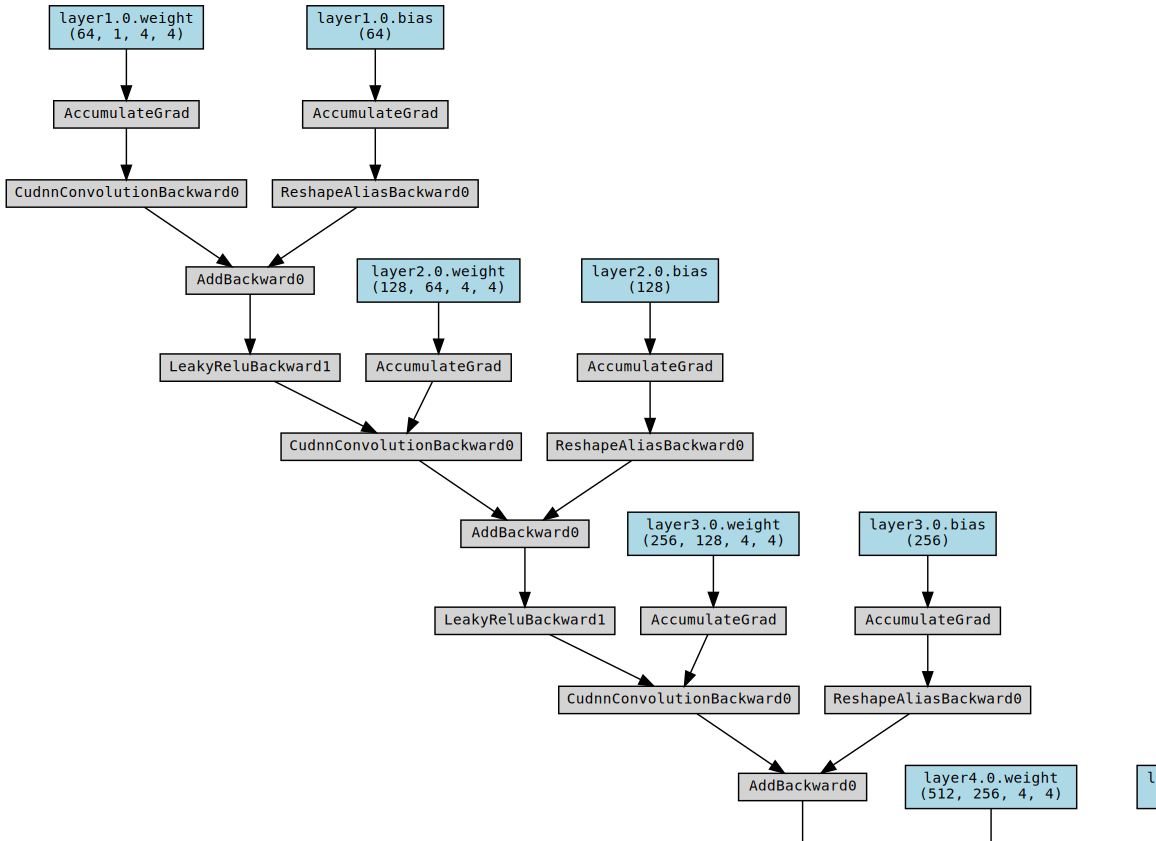

In [28]:
# 計算グラフを表示
img = make_dot(y, params=dict(D.named_parameters()))
display(img)

In [39]:
def train_model(G, D, dataloader, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 最適化手法の設定
    g_lr, d_lr = 0.001, 0.004 #0.00001,0.00004
    beta1, beta2 = 0.0, 0.9
    g_optimizer = torch.optim.Adam(G.parameters(), g_lr, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), d_lr, [beta1, beta2])

    # 誤差関数を定義
    criterion = nn.BCEWithLogitsLoss(reduction='mean')

    # パラメータをハードコーディング
    z_dim = 20
    mini_batch_size = 64

    # ネットワークをGPUへ
    G.to(device)
    D.to(device)

    G.train()  # モデルを訓練モードに
    D.train()  # モデルを訓練モードに

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # 画像の枚数
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size

    # イテレーションカウンタをセット
    iteration = 1
    logs = []
    d_loss_list = []
    g_loss_list = []

    # epochのループ
    for epoch in range(num_epochs):

        # 開始時刻を保存
        t_epoch_start = time.time()
        epoch_g_loss = 0.0  # epochの損失和
        epoch_d_loss = 0.0  # epochの損失和

        print('-------------')
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')
        print('（train）')

        # データローダーからminibatchずつ取り出すループ
        for imges in dataloader:
            imges = imges.to(device)

            # 正解ラベルと偽ラベルを作成
            # epochの最後のイテレーションはミニバッチの数が少なくなる
            mini_batch_size = imges.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # 真の画像を判定
            d_out_real = D(imges)

            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)
            
            label_real = label_real.type_as(d_out_real.view(-1))
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            label_fake = label_fake.type_as(d_out_fake.view(-1))
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()

            d_loss.backward()
            
            #######cropping
#             nn.utils.clip_grad_norm_(D.parameters(), 5)  ####3
            #######
            d_optimizer.step()

            # --------------------
            # 2. Generatorの学習
            # --------------------
            # 偽の画像を生成して判定
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            input_z = input_z.view(input_z.size(0), input_z.size(1), 1, 1)
            fake_images = G(input_z)
            d_out_fake = D(fake_images)

            # 誤差を計算
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # バックプロパゲーション
            g_optimizer.zero_grad()
            d_optimizer.zero_grad()
            g_loss.backward()
            
#             print(G.state_dict()['layer1.0.weight'].grad)
            
            ######cropping
#             nn.utils.clip_grad_norm_(G.parameters(), 5)
            ######
            g_optimizer.step()

            # --------------------
            # 3. 記録
            # --------------------
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            iteration += 1

        # epochのphaseごとのlossと正解率
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_D_Loss:{:.4f} ||Epoch_G_Loss:{:.4f}'.format(
            epoch, epoch_d_loss/batch_size, epoch_g_loss/batch_size))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        
        d_loss_list.append(epoch_d_loss)
        g_loss_list.append(epoch_g_loss)
        t_epoch_start = time.time()

    return g_loss_list, d_loss_list

In [40]:
# 学習・検証を実行する
# 6分ほどかかる
num_epochs = 30
g_loss_list, d_loss_list = train_model(
    G, D, dataloader=dataloader, num_epochs=num_epochs)
G_update, D_update = G,D

使用デバイス： cuda:0
-------------
Epoch 0/30
-------------
（train）
-------------
epoch 0 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45883.3080
timer:  17.1121 sec.
-------------
Epoch 1/30
-------------
（train）
-------------
epoch 1 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45878.0601
timer:  17.0959 sec.
-------------
Epoch 2/30
-------------
（train）
-------------
epoch 2 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45874.5957
timer:  17.1031 sec.
-------------
Epoch 3/30
-------------
（train）
-------------
epoch 3 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45871.0604
timer:  17.0674 sec.
-------------
Epoch 4/30
-------------
（train）
-------------
epoch 4 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45867.5041
timer:  17.0669 sec.
-------------
Epoch 5/30
-------------
（train）
-------------
epoch 5 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45864.7696
timer:  17.0736 sec.
-------------
Epoch 6/30
-------------
（train）
-------------
epoch 6 || Epoch_D_Loss:0.0000 ||Epoch_G_Loss:45862.3283
timer:  17.0610 sec.
------------

In [32]:
g_log_loss_list = [np.log(i) for i in g_loss_list]
d_log_loss_list = [np.log(i) for i in d_loss_list]

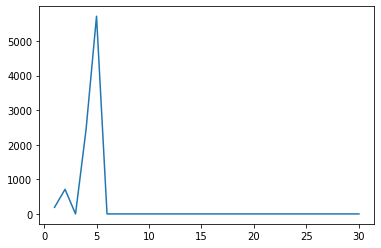

In [33]:
plt.plot(np.linspace(1,30,30),d_loss_list)

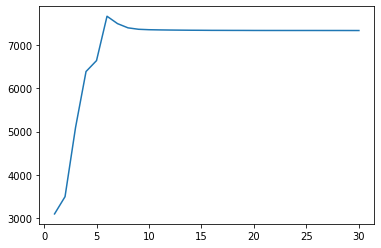

In [34]:
plt.plot(np.linspace(1,30,30),g_loss_list)

In [37]:
g_loss_list[0]/16

193.7989215059206

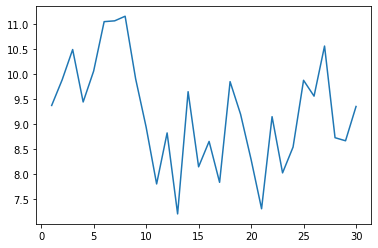

In [34]:
plt.plot(np.linspace(1,30,30),d_log_loss_list)

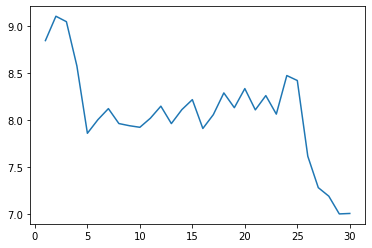

In [35]:
plt.plot(np.linspace(1,30,30),g_log_loss_list)

In [44]:
g_log_loss_list = [np.log(i) for i in g_loss_list]
d_log_loss_list = [np.log(i) for i in d_loss_list]

In [41]:
np.linspace(1,100,100)

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [86]:
G_update.state_dict()

OrderedDict([('layer1.0.weight',
              tensor([[[[ 2.4530e-02,  4.8554e-02, -2.8769e-02, -2.7684e-02],
                        [ 9.4521e-02, -3.9383e-02, -3.0807e-02, -1.7654e-02],
                        [-2.7581e-02, -1.7962e-02, -7.6384e-03, -3.1776e-03],
                        [-3.4322e-02, -8.2616e-03, -3.0602e-02, -2.3894e-02]],
              
                       [[-1.1266e-02, -5.7220e-03, -9.4780e-03, -1.8901e-03],
                        [ 6.2537e-04, -1.7109e-02, -2.6136e-02, -3.0927e-02],
                        [ 1.7210e-02, -3.8322e-02, -1.3539e-04, -1.4229e-02],
                        [-1.9005e-02, -4.6260e-02, -4.9052e-02, -4.3014e-02]],
              
                       [[-2.0498e-02,  5.1585e-02,  1.3832e-02, -2.0778e-02],
                        [-6.9062e-02,  1.1939e-01,  3.5285e-03,  3.8088e-02],
                        [ 5.1103e-02, -7.0457e-03,  2.6685e-02, -1.9292e-02],
                        [ 2.5364e-02,  4.3729e-02,  8.6616e-02, -9.1857e-03]]

In [91]:
print(G_update.state_dict()['layer1.0.weight'].grad)

None


In [85]:
G_update.layer1.state_dict()

OrderedDict([('0.weight',
              tensor([[[[ 2.4530e-02,  4.8554e-02, -2.8769e-02, -2.7684e-02],
                        [ 9.4521e-02, -3.9383e-02, -3.0807e-02, -1.7654e-02],
                        [-2.7581e-02, -1.7962e-02, -7.6384e-03, -3.1776e-03],
                        [-3.4322e-02, -8.2616e-03, -3.0602e-02, -2.3894e-02]],
              
                       [[-1.1266e-02, -5.7220e-03, -9.4780e-03, -1.8901e-03],
                        [ 6.2537e-04, -1.7109e-02, -2.6136e-02, -3.0927e-02],
                        [ 1.7210e-02, -3.8322e-02, -1.3539e-04, -1.4229e-02],
                        [-1.9005e-02, -4.6260e-02, -4.9052e-02, -4.3014e-02]],
              
                       [[-2.0498e-02,  5.1585e-02,  1.3832e-02, -2.0778e-02],
                        [-6.9062e-02,  1.1939e-01,  3.5285e-03,  3.8088e-02],
                        [ 5.1103e-02, -7.0457e-03,  2.6685e-02, -1.9292e-02],
                        [ 2.5364e-02,  4.3729e-02,  8.6616e-02, -9.1857e-03]],
     

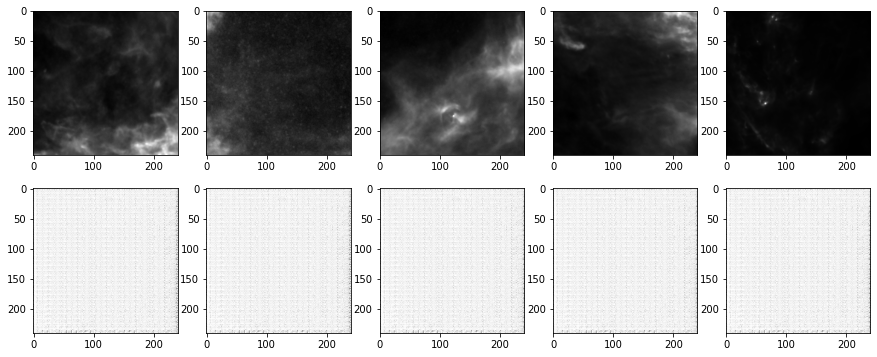

In [38]:
# 生成画像と訓練データを可視化する
# 本セルは良い感じの画像が生成されるまで、何度も実行し直しています。

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 入力の乱数生成
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)
fixed_z = fixed_z.view(fixed_z.size(0), fixed_z.size(1), 1, 1)

# 画像生成
G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 訓練データ
batch_iterator = iter(dataloader)  # イテレータに変換
imges = next(batch_iterator)  # 1番目の要素を取り出す


# 出力
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 上段に訓練データを
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 下段に生成データを表示する
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')